In [56]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch
from torchvision.utils import make_grid
import numpy  as np
import matplotlib.pyplot as plt
import  image_loader as il
import torch.utils.data
from torch.utils.data import DataLoader

In [57]:
alex = models.vgg16(pretrained=True)

print(alex)
num_features = alex.classifier[6].in_features
alex.classifier[6] = nn.Linear(num_features, 5) # output labels

loader = il.DatasetLoader.initial()
train = loader.load_tensors(0, 100)
test = loader.load_tensors(100, 150)

train_set = DataLoader(il.ImageDataset(train), batch_size=1, shuffle=True, num_workers=4)
test_set = DataLoader(il.ImageDataset(test), batch_size=1, shuffle=True, num_workers=4)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [58]:
def to_3_dim_image(img):
        layer = img[0].tolist()
        t = torch.tensor([layer] * 3)
        t[t==0] = 0.5
        return t
        
def create_empty_image(shape = (3, 224, 224)):
        t = torch.zeros(shape)
        t[t==0] = 0.5
        return t

def visualize_cell(input_data:dict, output_data:dict):
    lables = [(i, to_3_dim_image(input_data[i])) if i in input_data else (i, create_empty_image()) for i in il.labels_attributes]
    lables.sort(key=lambda x:x[0])
    inputs = list(filter(lambda x: x[0] == 'input', input_data.items()))
    merged = lables + inputs    
    print(list(map(lambda x: x[0], merged)))
    imgs = make_grid(list(map(lambda x: x[1], merged)), padding=50).numpy()
    plt.imshow(np.transpose(imgs, (1,2,0)))
    plt.figure()
    
    output_lables = [(i, to_3_dim_image(output_data[i])) if i in output_data else (i, create_empty_image()) for i in il.labels_attributes]
    merged_lables = output_lables
    merged_lables.sort(key=lambda x:x[0])    
    print(list(map(lambda x: x[0], merged_lables)))
    imgs = make_grid(list(map(lambda x: x[1], merged_lables)), padding=50).numpy()
    plt.imshow(np.transpose(imgs, (1,2,0)))

def visualize_tensor(labels:torch.Tensor, inputs:torch.Tensor):
    labels = [to_3_dim_image(i) for i in labels]
    inputs = [inputs[0]]
    merged = labels + inputs
    imgs = make_grid(merged, padding=50).numpy()
    plt.imshow(np.transpose(imgs, (1, 2, 0)))
    plt.figure()
    

In [63]:
class GAIN:
    
    alpfa = 1
    dablu = 10
    def __init__(self, model, layer_name: str, gpu=False):
        self.model = model

        # set cuda
        self.gpu = gpu
        if self.gpu:
            self.model = self.model.cuda()
            self.tensor_source = torch.cuda
            self.device = 'cuda'
        else:
            self.tensor_source = torch
            self.device = 'cpu'

        self._last_activation = None
        self._last_grad = None

        self.__register_callbacks(layer_name)
        self.loss_cl = torch.nn.BCEWithLogitsLoss()

    def __register_callbacks(self, layer_name: str):

        def forward_callback(module, input_, output_):
            self._last_activation = output_

        def backward_callback(module, grad_in, grad_out):
            self._last_grad = grad_out[0]

        found_layer = False
        for idx, layer in self.model.named_modules():
            if idx == layer_name:
                found_layer = True
                layer.register_forward_hook(forward_callback)
                layer.register_backward_hook(backward_callback)
                break

        if not found_layer:
            raise ValueError("Not found layer:{}".format(layer_name))

    def train(self, data_loader: torch.utils.data.DataLoader, epoch_number:int = 10):
        self.model.train()
        best_model = self.model
        best_total = 1e9
        for epoch in range(epoch_number):
            
            loss_cl_sum = 0
            loss_am_sum = 0
            loss_segments_sum = 0
            total_loss_sum = 0
            total_idx = len(data_loader)
            for idx, (inputs, segments, labels) in enumerate(data_loader):
                inputs = inputs[0].to(self.device)
                labels = labels[0].to(self.device)
                segments = segments[0].to(self.device)
                # size always 5
                loss_total, loss_cl, loss_am, loss_e, a_c, i_star = self.russian_forward(best_model, inputs, segments, labels)
                ll = self.loss_cl(a_c, segments)
                ll.backward()
                # loss_total.backward()
                total_loss_sum += loss_total.item()
                loss_cl_sum += loss_cl.item()
                loss_am_sum += loss_am.item()
                loss_segments_sum += loss_e.item() 
            loss_cl_sum = loss_cl_sum / (len(data_loader) * 5) 
            loss_am_sum = loss_am_sum / (len(data_loader) * 5)
            loss_segments_sum = loss_segments_sum / (len(data_loader) * 5)
            total_loss_sum = total_loss_sum / (len(data_loader) * 5)
            
            print("=" * 10)
            print("End epoch: {}/{}".format(epoch + 1, epoch_number + 1))
            print("Total Loss: {}, classification loss: {}, loss AM: {}, loss segments: {}"
                  .format(total_loss_sum, loss_cl_sum, loss_am_sum, loss_segments_sum))
            if total_loss_sum < best_total:
                best_model = self.model
                best_total = total_loss_sum
            
        return best_model
            
    def russian_forward(self, model, input_image_data, mask_label_data, label_data):
        # N -- labels number
        # input_image_data  BS [5 x 3 x 244 x 244]
        # N == BS
        output_classification = model(input_image_data) # BS x N
        
        # required for get dx / dy for substitution to eq 1
        grad_target = (output_classification.float() * label_data).sum()
        grad_target.backward(gradient=output_classification * label_data, retain_graph=True)

        model.zero_grad()

        # Eq 1
        # find w_c from evaluate grad model for specified layer
        layer_gradient = self._last_grad # BS x C x H x W
        
        bs, c, h, w = layer_gradient.size()
        w_c = F.avg_pool2d(layer_gradient, (h, w), 1)  # BS x C x 1 x 1
        
        # Eq 2
        # reshape current weights for compability with w_c
        f_weights = self._last_activation 
        f_weights_new_shape = (1, f_weights.shape[0] * f_weights.shape[1], f_weights.shape[2], f_weights.shape[3]) # 1 x (BS x C) x H x W
        f_weights = f_weights.view(f_weights_new_shape)
        
        
        a_c = F.relu(F.conv2d(f_weights, w_c, groups=bs))
        a_c = F.interpolate(a_c, size=input_image_data.size()[2:], mode='bilinear', align_corners=False)
        a_c = a_c.permute((1, 0, 2, 3))
        # calculate old plain classification loss
        loss_cl = self.loss_cl(output_classification, label_data)

        # her we has output_classification, classification_loss, a_c
        i_star = self.__mask_image(input_image_data, a_c)
        
        # here we want decrease weights, which are'nt marked by previous model as segment-importanse 
        output_am = model(i_star)
        
        loss_am = (F.sigmoid(output_am) * label_data).sum() / (label_data.sum().type(self.tensor_source.FloatTensor) + 1.0)
        
        loss_e = ((mask_label_data - i_star) ** 2).sum()
        loss_total = loss_cl + self.alpfa * loss_am + self.dablu * loss_e

        return loss_total, loss_cl, loss_am, loss_e, a_c, i_star 
        
    sigma = 0.1
    omega = 0.9

    def __mask_image(self, data_image, a_c):
        # Eq 4
        # I don't understand bellow 3 lines
        a_c_min = a_c.min()
        a_c_max = a_c.max()
        
        a_c = a_c if (a_c_max - a_c_min).item() == 0 else (a_c - a_c_min) / (a_c_max - a_c_min)
    
        t_a_c = F.sigmoid(self.omega * (a_c - self.sigma))
        # Eq 3
        masked_image = data_image - (data_image * t_a_c)
        return masked_image


gg = GAIN(alex, "features.28", gpu=True)

best_model = gg.train(train_set, 10)

End epoch: 1/11
Total Loss: 174824.6828125, classification loss: 0.1455891135931015, loss AM: 0.0758460542857647, loss segments: 17482.4461640625
End epoch: 2/11
Total Loss: 174882.6564375, classification loss: 0.1466203521490097, loss AM: 0.07500061988830567, loss segments: 17488.2435
End epoch: 3/11
Total Loss: 173974.6918125, classification loss: 0.14632311010360718, loss AM: 0.07582259112596512, loss segments: 17397.44675
End epoch: 4/11
Total Loss: 174641.367125, classification loss: 0.14568495070934295, loss AM: 0.07550522920489311, loss segments: 17464.114734375
End epoch: 5/11
Total Loss: 174346.4655625, classification loss: 0.14687554144859313, loss AM: 0.07550772726535797, loss segments: 17434.624328125
End epoch: 6/11
Total Loss: 175428.85, classification loss: 0.14645571446418762, loss AM: 0.0750864907503128, loss segments: 17542.862796875
End epoch: 7/11
Total Loss: 175332.787375, classification loss: 0.14605092167854308, loss AM: 0.07536563044786453, loss segments: 17533.

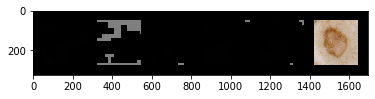

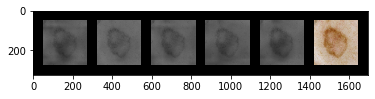

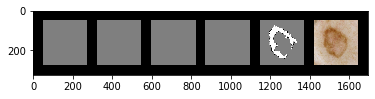

<Figure size 432x288 with 0 Axes>

In [66]:

for idx, (inputs, segments, labels) in enumerate(test_set):
    if idx <= 4:
        continue
    inputs = inputs[0].to('cuda')
    labels = labels[0].to('cuda')
    segments = segments[0].to('cuda')
    _, _, _, _, a_c, i_start = gg.russian_forward(best_model, inputs, segments, labels)
    a_c = a_c.cpu()
    i_start = i_start.cpu()
    inputs = inputs.cpu()
    visualize_tensor(a_c, inputs)
    visualize_tensor(i_start, inputs)
    visualize_tensor(segments, inputs)
    break